In [1]:
import torch
torch.manual_seed(67)
from torch.nn.utils.rnn import pad_sequence
from torchvision import transforms
from dataset import COCODataset
from vocabulary import END_TOKEN, PAD_TOKEN, START_TOKEN, Vocabulary
from checkpoint import save_checkpoint, load_checkpoint, unpack_checkpoint
import matplotlib.pyplot as plt


In [2]:
img_transform = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize((0.485, 0.456, 0.406),
                             (0.229, 0.224, 0.225))])
dataset = COCODataset(
    mode='val', img_transform=img_transform, caption_max_len=-1)

vocab = dataset.vocab

# Collate function for dataloader.
pad_idx = dataset.vocab(PAD_TOKEN)
def collate_fn(data):
    imgs, captions, img_paths, _ = zip(*data)

    imgs = torch.stack(imgs, dim=0)
    captions = pad_sequence(
        captions, batch_first=True, padding_value=pad_idx)
    caption_lengths = [len(caption) for caption in captions]

    return imgs, captions, caption_lengths, img_paths

# Dataloader.
val_loader = torch.utils.data.DataLoader(
    dataset=dataset,
    batch_size=1,
    shuffle=True,
    num_workers=1,
    collate_fn=collate_fn)

loading annotations into memory...
Done (t=0.29s)
creating index...
index created!


In [3]:
device = torch.device('cpu') #torch.device('cuda' if torch.cuda.is_available() else 'cpu')

baseline = torch.load('checkpoints/baseline_3.pth.tar', map_location=device)
baseline_encoder = baseline['encoder'].to(device)
baseline_encoder.eval()
baseline_decoder = baseline['decoder'].to(device)
baseline_decoder.eval()

baseline_glove = torch.load('checkpoints/glove_baseline_3.pth.tar', map_location=device)
baseline_glove_encoder = baseline_glove['encoder'].to(device)
baseline_glove_encoder.eval()
baseline_glove_decoder = baseline_glove['decoder'].to(device)
baseline_glove_decoder.eval()

att_basic = torch.load('checkpoints/basic_att_3.pth.tar', map_location=device)
att_basic_encoder = att_basic['encoder'].to(device)
att_basic_encoder.eval()
att_basic_decoder = att_basic['decoder'].to(device)
att_basic_decoder.device = device
att_basic_decoder.eval()

att_glove = torch.load('checkpoints/glove_att_3.pth.tar', map_location=device)
att_glove_encoder = att_glove['encoder'].to(device)
att_glove_encoder.eval()
att_glove_decoder = att_glove['decoder'].to(device)
att_glove_decoder.device = device
att_glove_decoder.eval()

att_bert = torch.load('checkpoints/bert_attention_3.pth.tar', map_location=device)
att_bert_encoder = att_bert['encoder'].to(device)
att_bert_encoder.eval()
att_bert_decoder = att_bert['decoder'].to(device)
att_bert_decoder.device = device
att_bert_decoder.eval();

In [4]:
def stringify_caption(cap):
    # Remove <start>, <end> and <pad> tokens.
    cleaned = [w for w in cap if w not in [vocab(START_TOKEN), vocab(END_TOKEN), vocab(PAD_TOKEN)]]
    seq = [vocab.i2w[id] for id in cleaned]
    return ' '.join(seq)

In [5]:

def caption_all_models(imgs, captions, caption_lengths, img_paths):
    with torch.no_grad():

        imgs = imgs.to(device)
        captions = captions.to(device)
        
        img_path = img_paths[0]
        print(f'Image path: {img_path}')
        fig, ax = plt.subplots()
        image = plt.imread(img_path)
        ax.imshow(image) 
        plt.show()

        print(f'Actual: {stringify_caption(captions.tolist()[0])}')

        ### BASELINE ###
        def baseline_pred():
            img_features = baseline_encoder(imgs)
            scores = baseline_decoder(img_features, captions)
            _, preds = torch.max(scores, dim=2)
            return stringify_caption(preds.tolist()[0])
        print(f'Baseline: {baseline_pred()}')

        ### BASELINE GLOVE ###
        def baseline_glove_pred():
            img_features = baseline_glove_encoder(imgs)
            scores = baseline_glove_decoder(img_features, captions)
            _, preds = torch.max(scores, dim=2)
            return stringify_caption(preds.tolist()[0])
        print(f'Baseline GloVe: {baseline_glove_pred()}')

        ### BASIC ATTENTION ###
        def basic_attention_pred():
            img_features = att_basic_encoder(imgs)
            scores, captions_sorted, decode_lengths, attention_weights = att_basic_decoder(img_features, captions, caption_lengths)
            targets = captions_sorted[:, 1:]
            _, preds = torch.max(scores, dim=2)
            return stringify_caption(preds[0][:decode_lengths[0]].tolist())
        print(f'Basic Attention: {basic_attention_pred()}')

        ### GLOVE ATTENTION ###
        def glove_attention_pred():
            img_features = att_glove_encoder(imgs)
            scores, captions_sorted, decode_lengths, attention_weights = att_glove_decoder(img_features, captions, caption_lengths)
            targets = captions_sorted[:, 1:]
            _, preds = torch.max(scores, dim=2)
            return stringify_caption(preds[0][:decode_lengths[0]].tolist())
        print(f'GloVe Attention: {glove_attention_pred()}')

        ### BERT ATTENTION ###
        def bert_attention_pred():
            img_features = att_bert_encoder(imgs)
            scores, captions_sorted, decode_lengths, attention_weights = att_bert_decoder(img_features, captions, caption_lengths)
            targets = captions_sorted[:, 1:]
            _, preds = torch.max(scores, dim=2)
            return stringify_caption(preds[0][:decode_lengths[0]].tolist())
        print(f'BERT Attention: {bert_attention_pred()}')

Image path: cocoapi/images/val2014/COCO_val2014_000000308264.jpg


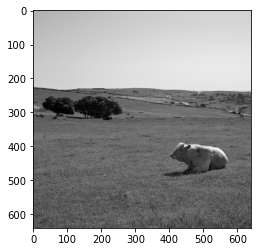

Actual: an animal of some sort on a field of some sort .
Baseline: a animal grazing a sort of a field . grass grass .
Baseline GloVe: a animal is a sort of a grassy . grass grass .
Basic Attention: a animal is sheep sheep in a field . grass grass
GloVe Attention: a animal laying sheep animals on a field grass grass
BERT Attention: a dog in a sort on a field in some sort .

Image path: cocoapi/images/val2014/COCO_val2014_000000286119.jpg


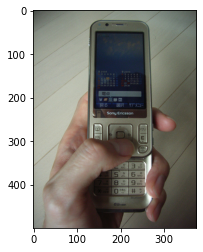

Actual: a person using a cell phone with their thumb .
Baseline: a cell holding a cell phone with a hand open
Baseline GloVe: a cell holding a cell phone with a hand .
Basic Attention: a person holding a cell phone in a hands .
GloVe Attention: a person holding a cell phone on a cell .
BERT Attention: a person using a cell phone with their hand .


In [6]:
itr_val_loader = iter(val_loader)
# 1
imgs, captions, caption_lengths, img_paths = next(itr_val_loader)
caption_all_models(imgs, captions, caption_lengths, img_paths)

print()

# 2
imgs, captions, caption_lengths, img_paths = next(itr_val_loader)
caption_all_models(imgs, captions, caption_lengths, img_paths)